## Import Libraries and File

In [443]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

from imblearn.over_sampling import SMOTE # Handle sampling imbalance

from sklearn.preprocessing import OneHotEncoder #One hot encoding
from sklearn.compose import make_column_transformer #Transform one hot encoding
from sklearn.impute import SimpleImputer # Imputing missing data
from sklearn.model_selection import train_test_split # To split data into train and test
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV # For faster hyperparameter tuning
from sklearn.model_selection import cross_val_score # Model evaluation
from sklearn.metrics import f1_score #classification assessment
from sklearn.model_selection import KFold # Cross-validation

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier

In [50]:
#import file
df = pd.read_csv(r"e-commerce.csv")

#check first few rows data
display(df.head())

#check data types
df.info()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

### Data Dictionary

In [280]:
#import file
df_dict = pd.read_csv(r"e-commerce-dictionary.csv")
pd.set_option('display.max_colwidth', None)
df_dict

,Table,Variable,Discerption
0,ecommerce,CustomerID,Unique customer ID
1,ecommerce,Churn,Churn Flag
2,ecommerce,Tenure,Tenure of customer in organization
3,ecommerce,PreferredLoginDevice,Preferred login device of customer
4,ecommerce,CityTier,City tier
5,ecommerce,WarehouseToHome,Distance in between warehouse to home of customer
6,ecommerce,PreferredPaymentMode,Preferred payment method of customer
7,ecommerce,Gender,Gender of customer
8,ecommerce,HourSpendOnApp,Number of hours spend on mobile application or website
9,ecommerce,NumberOfDeviceRegistered,Total number of deceives is registered on particular customer


### Data Quality Check - Duplicates

In [52]:
#check for any rows with duplicate - as it might cause model performance issue
#duplicated features
dup_features = df.loc[df.drop(columns=["CustomerID","Churn"]).duplicated()==True,:]
#duplicated features+target
dup_df = df.loc[df.drop(columns=["CustomerID"]).duplicated()==True,:]
print(f'# duplicated features:{len(dup_features)},\n# duplicated features+target:{len(dup_df)}')

# duplicated features:556,
# duplicated features+target:556


There are different customers with duplicated features. However, considering the business domain this duplication is possible to happen by chance and not due to data issue. In addition target data is consistent for each duplicates, so the duplicate was left as is.

### Data Quality Check - Data Consistency

In [126]:
# Numerical variable:
display(df.describe())

# Categorical variable:
def display_count(df):
    cat_col = df.loc[:,df.dtypes=='object'].columns
    for col in cat_col:
        display(df[col].value_counts())
        
display_count(df)

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.221492
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.193869
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,325.000000


Mobile Phone    2765
Computer        1634
Phone           1231
Name: PreferredLoginDevice, dtype: int64

Debit Card          2314
Credit Card         1501
E wallet             614
UPI                  414
COD                  365
CC                   273
Cash on Delivery     149
Name: PreferredPaymentMode, dtype: int64

Male      3384
Female    2246
Name: Gender, dtype: int64

Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64

Married     2986
Single      1796
Divorced     848
Name: MaritalStatus, dtype: int64

Data quality issue observed, assuming the context of the data being customer data of e-commerce platform:
1. PreferredLoginDevice: mobile phone recorded as both "Phone" and "Mobile Phone" - to standardize
2. PreferredPaymentMode: credit card recorded as both "Credit Card" and "CC" & cash on delivery recorded as both "COD" and "Cash on Delivery" - to standardize
3. PreferedOrderCat: mobile phone recorded as both "Mobile" and "Mobile Phone" - to standardize

In [127]:
# PreferredLoginDevice - "Phone" -> "Mobile Phone"
# PreferredPaymentMode - "CC" -> "Credit Card"
# PreferredPaymentMode - "COD" -> "Cash on Delivery"
# PreferedOrderCat - "Mobile" -> "Mobile Phone"
df_new = df.replace(["Phone","CC","COD","Mobile"],["Mobile Phone","Credit Card","Cash on Delivery","Mobile Phone"])

# Check new data 
display_count(df_new)

Mobile Phone    3996
Computer        1634
Name: PreferredLoginDevice, dtype: int64

Debit Card          2314
Credit Card         1774
E wallet             614
Cash on Delivery     514
UPI                  414
Name: PreferredPaymentMode, dtype: int64

Male      3384
Female    2246
Name: Gender, dtype: int64

Mobile Phone          2080
Laptop & Accessory    2050
Fashion                826
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64

Married     2986
Single      1796
Divorced     848
Name: MaritalStatus, dtype: int64

### Data Quality Check - Missing value

In [65]:
#check missing values
print('% of missing per columns:')
df_missing = df[df.columns[df.isnull().any()].tolist()]
display(df_missing
        .isna()
        .apply(sum)/len(df)*100)

print(f'total {sum(df.isnull().any(axis=1))} missing rows out of {len(df)} columns ({round(sum(df.isnull().any(axis=1))/len(df)*100)}%)')

% of missing per columns:


Tenure                         4.689165
WarehouseToHome                4.458259
HourSpendOnApp                 4.529307
OrderAmountHikeFromlastYear    4.706927
CouponUsed                     4.547069
OrderCount                     4.582593
DaySinceLastOrder              5.452931
dtype: float64

total 1856 missing rows out of 5630 columns (33%)


As missing value for all the columns are around 5%, sufficient data available to use above columns for creating model

For missing value, there are several options to consider:
1. Exclude missing data - not considered as total missing rows are significant (33%)
2. Impute using central tendency (mean/median/mode)
3. Impute using info from other features (mice/knn imputer)

Option 2 and 3 are to be considered in model training

### Train-test Split

In [129]:
#split data into train and test set at 80:20 ratio

# split target and feature variables
X = df_new.loc[:,((df_new.columns != 'Churn')&(df_new.columns != "CustomerID"))]
y = df_new.loc[:,df_new.columns == 'Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

## Exploratory Data Analysis

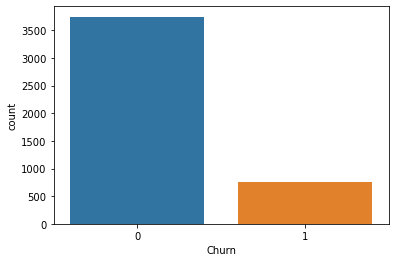

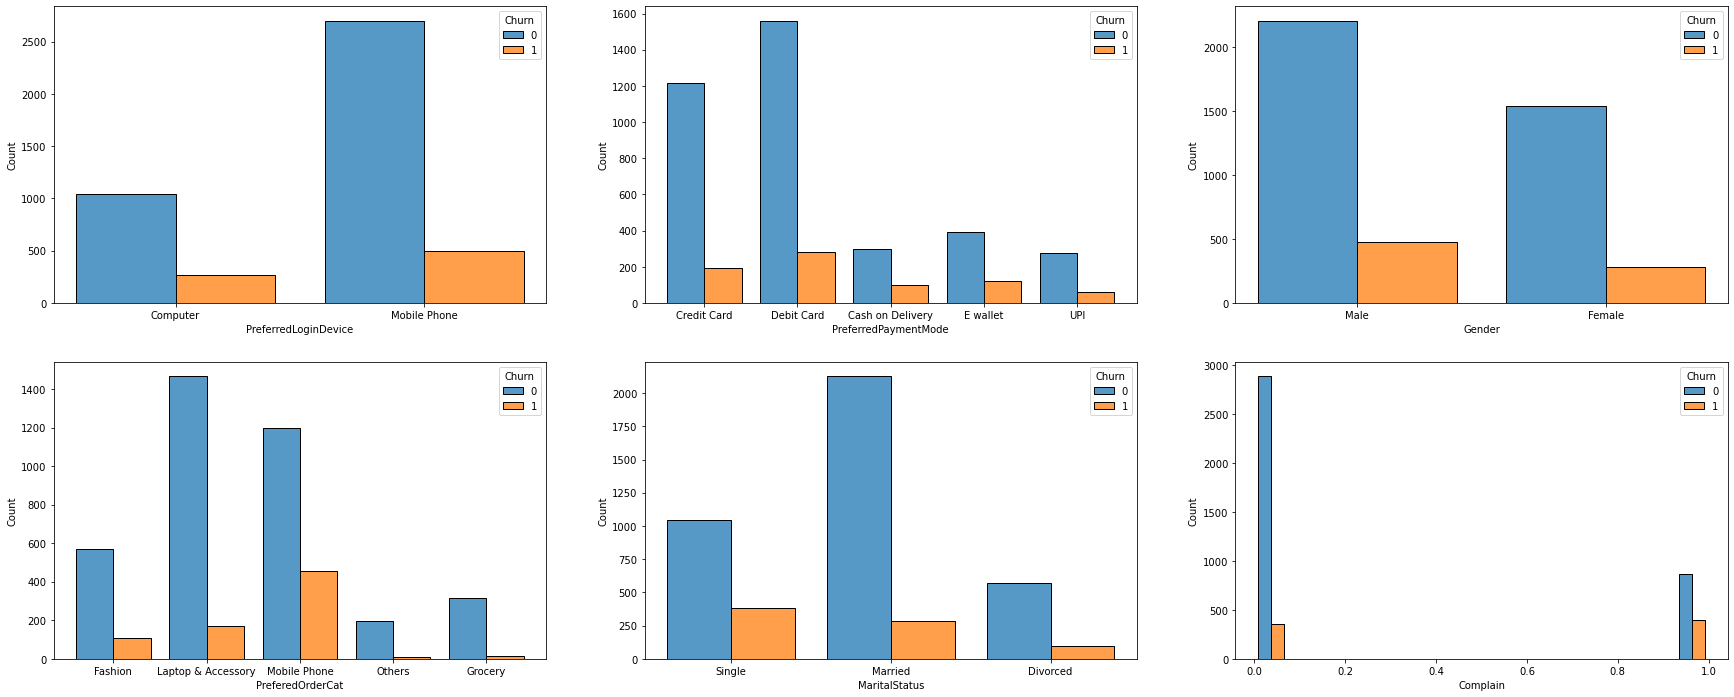

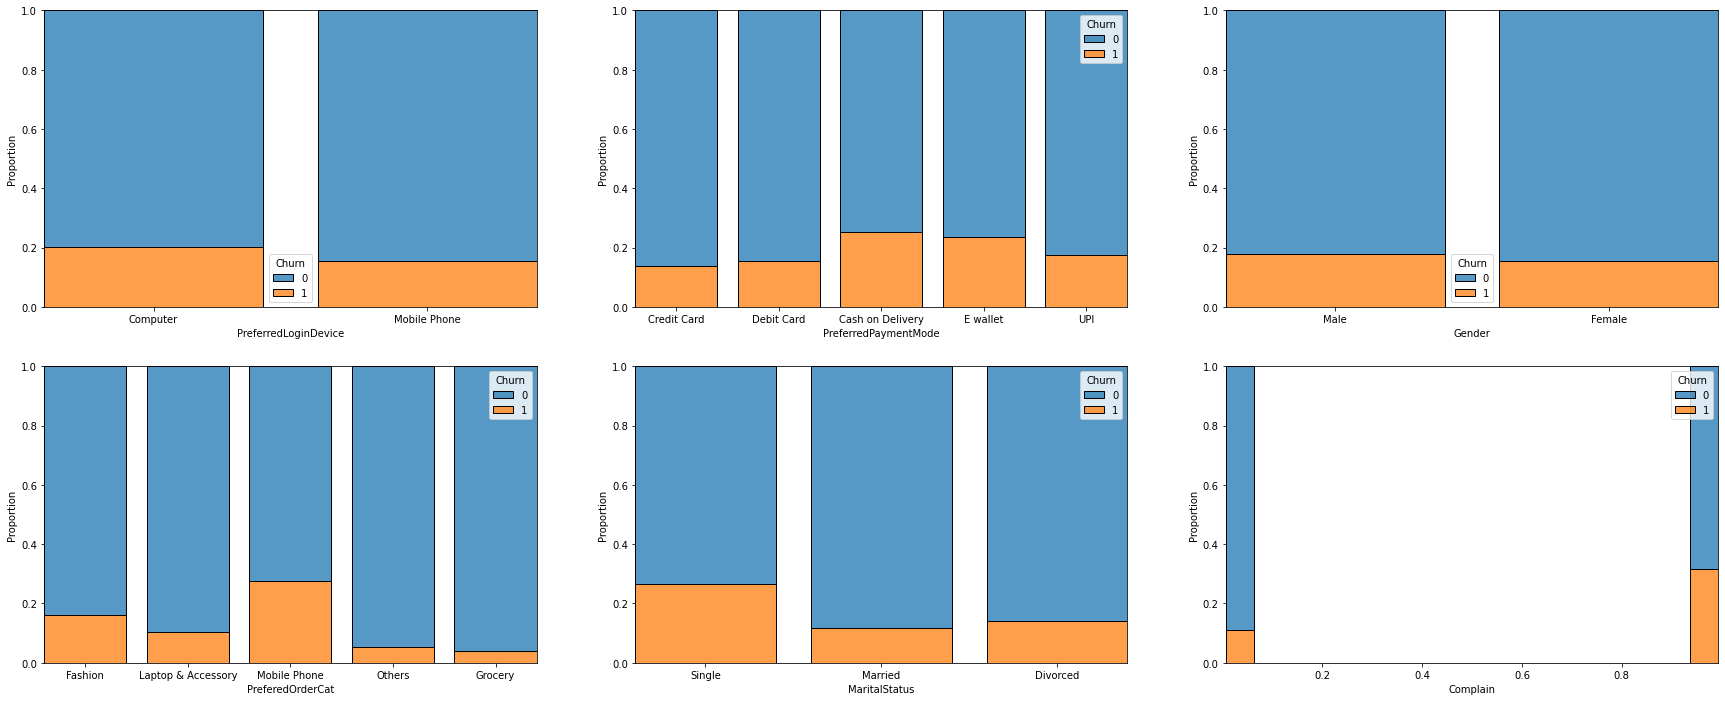

In [217]:
#target
sns.countplot(data=y_train, x="Churn")

#categorical
def plot_dist(features, X,y, multiple="dodge", stat = 'count'):
    df = pd.concat([y,X], axis=1)
    fig, ax = plt.subplots(ncols = 3, nrows = math.ceil(len(features)/3), figsize=(30,12))
    for x in range(len(features)):
        i = math.floor(x/3); j = x % 3 #define subplot row and column index
        sns.histplot(ax = ax[i,j], data = df, x= features[x], hue=df.columns[0], multiple=multiple, stat=stat, shrink=.8)
    plt.show()

cat_col = X_train.loc[:,X.dtypes == 'object'].columns.to_list()
cat_col.append("Complain")
plot_dist(cat_col,X_train,y_train)
plot_dist(cat_col,X_train,y_train,multiple="fill",stat = "proportion")

Observations:
1. Data has significantly more no churn data relative to churn - this might skew predictive model towards no churn. For example, based on the number of customers by PreferredLoginDevice, there seemsto be more people not churning that prefers Mobile Phone, however proportion wise there's not much difference in the churn/no churn ratio between devices --> To try out oversampling/undersampling using SMOTE to balance the class

2. PreferedOrderCat related to churn, particularly for Mobile Phone where more churn seen from both count/proportion.

3. Single customers have higher churn, despite married people being the main customer base.

4. Customers who complained are more likely to churn

5. Customers paying using card (Debit/Credit) less likely to churn

5. No notable difference from other categorical features

numerical features: ['Tenure', 'WarehouseToHome', 'CityTier', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'OrderCount', 'CashbackAmount', 'DaySinceLastOrder', 'NumberOfAddress', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'CouponUsed']

Count histogram:


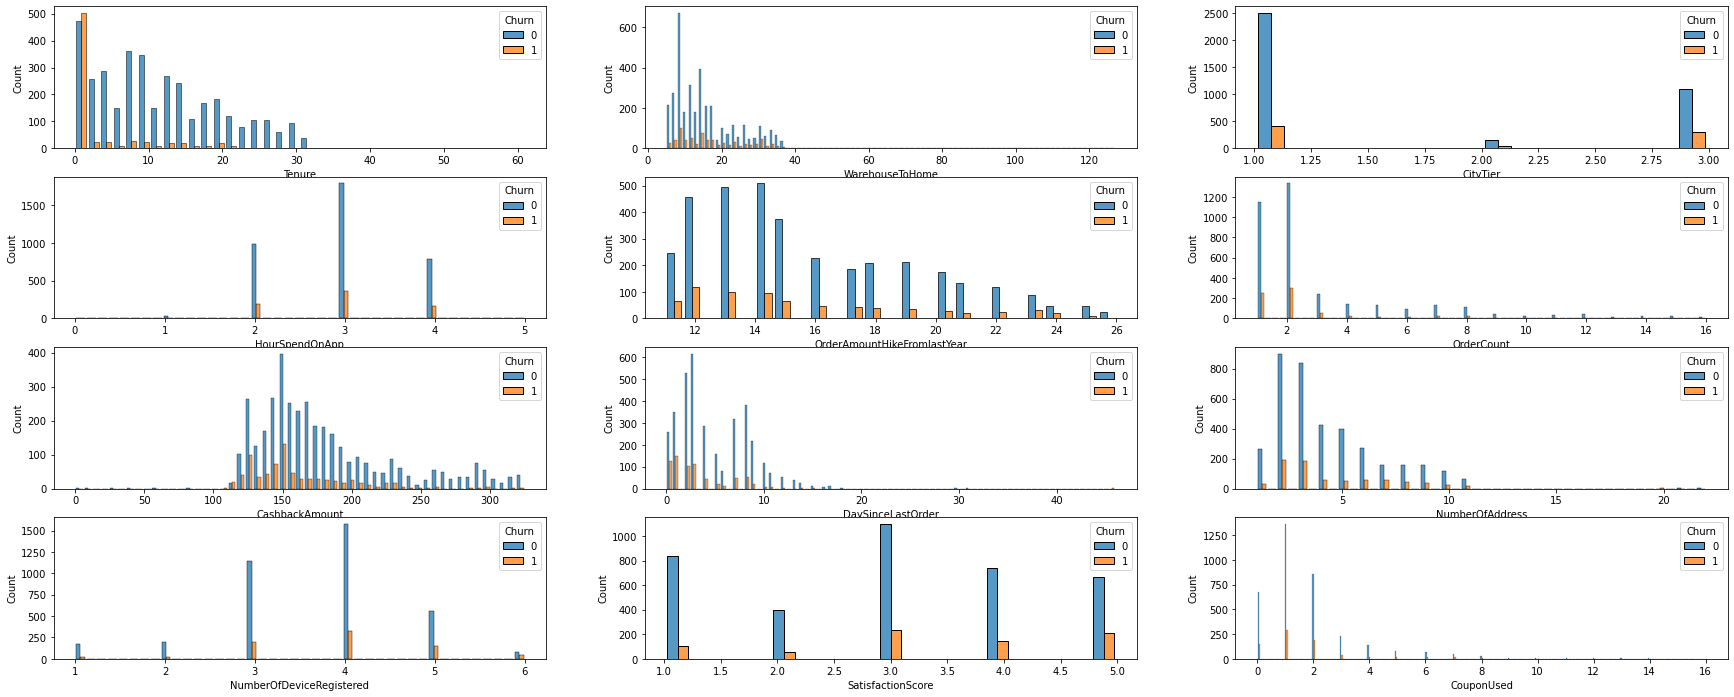


Proportion histogram:


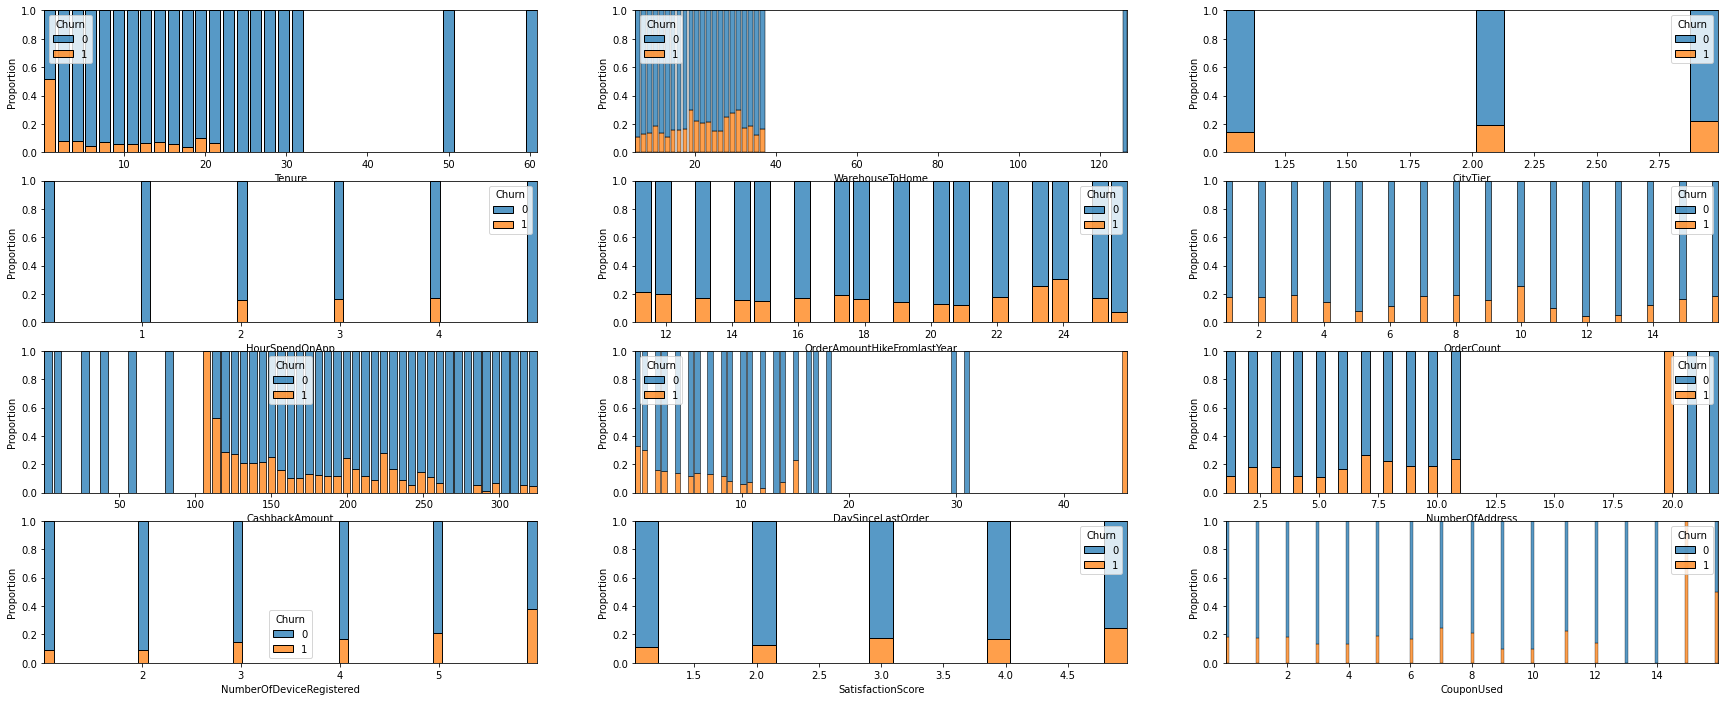

In [222]:
# numerical
num_col = list(set(X_train.columns.to_list()) - set(cat_col))
print(f"numerical features: {num_col}")
#plot
print("\nCount histogram:")
plot_dist(num_col,X_train,y_train) # count histogram
print("\nProportion histogram:")
plot_dist(num_col,X_train,y_train,multiple="fill",stat = "proportion") #proportion histogram

Observed that: 
- Tenure: the customers who churned are concentrated at low tenure.
- CashbackAmount: churn/no churn proportion increases as Cashback Amount decreases. However this observation does not hold for the small proportion of customers with Cashback Amount < 100
- DaySinceLastOrder: churn/no churn proportion increases as DaySinceLastOrder decreases.

### Outlier identification

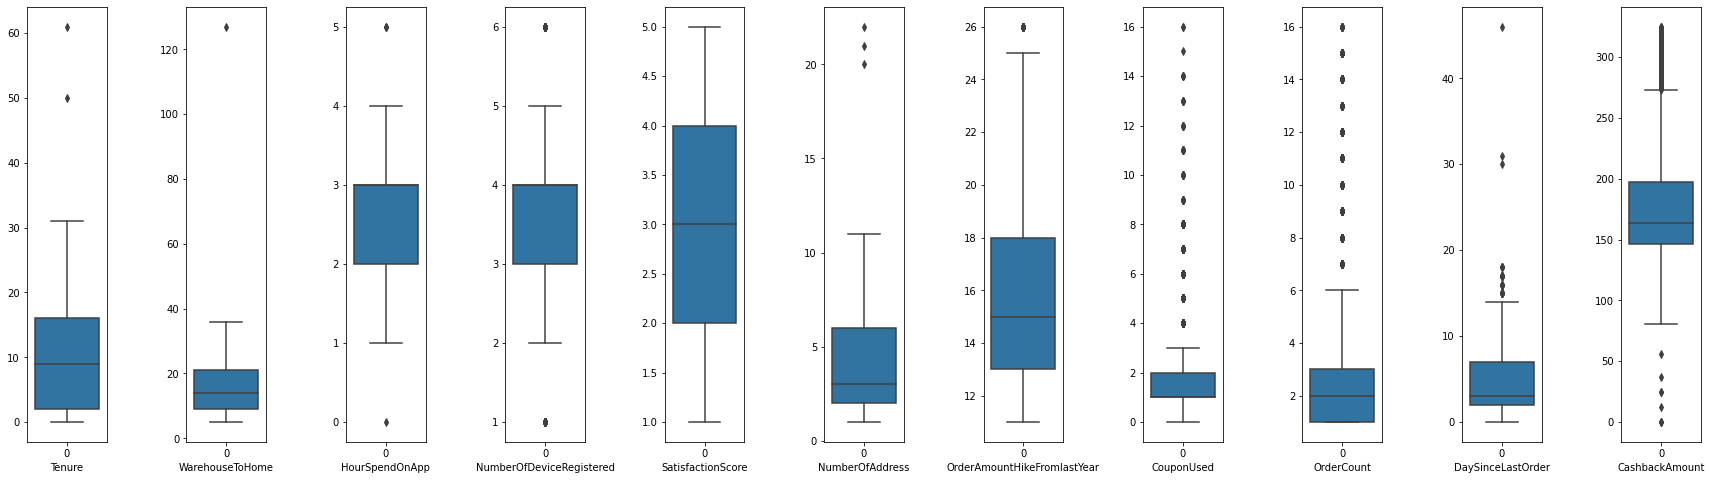

lower 3 sigma limit:
Tenure                        -15.463446
WarehouseToHome                -9.698604
HourSpendOnApp                  0.767718
NumberOfDeviceRegistered        0.605861
SatisfactionScore              -1.085525
NumberOfAddress                -3.497786
OrderAmountHikeFromlastYear     4.693548
CouponUsed                     -3.924180
OrderCount                     -5.659975
DaySinceLastOrder              -6.374923
CashbackAmount                 30.126475
dtype: float64

upper 3 sigma limit:
Tenure                          35.836319
WarehouseToHome                 41.140670
HourSpendOnApp                   5.097618
NumberOfDeviceRegistered         6.786679
SatisfactionScore                7.220072
NumberOfAddress                 11.892546
OrderAmountHikeFromlastYear     26.740344
CouponUsed                       7.430698
OrderCount                      11.600329
DaySinceLastOrder               15.455966
CashbackAmount                 324.636847
dtype: float64


In [116]:
# Visualize using boxplot
def box_outlier(df):
    num_features = df.loc[:,df.dtypes != 'object'].columns
    fig, ax = plt.subplots(ncols = len(num_features), figsize=(30,8)) #
    plt.subplots_adjust(wspace = 1)
    for i in range(len(num_features)):
        sns.boxplot(ax = ax[i], data = df[num_features[i]], showfliers = True)
        ax[i].set_xlabel(num_features[i])
    plt.show()
    
box_outlier(X_train.drop(columns=["CityTier","Complain"])) #exclude ordinal columns

# check upper/lower limit of 3 sigma
num_df = X_train.loc[:,X_train.dtypes != 'object'].drop(columns=["CityTier","Complain"])
lower_3sd = num_df.mean() - 3*num_df.std()
upper_3sd = num_df.mean() + 3*num_df.std()
print(f'lower 3 sigma limit:\n{lower_3sd}\n')
print(f'upper 3 sigma limit:\n{upper_3sd}')

Extreme outliers from columns: 
- Upper: 'Tenure', 'WarehouseToHome', 'NumberofAddress', 'DaySinceLastOrder'
- Lower: 'CashbackAmount'

to drop rows with extreme outlier

In [264]:
#Drop Outliers

outlier_col = ['Tenure', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder','CashbackAmount']
outlier_type = ['upper','upper','upper','upper','lower']
outlier_limit = [36,41,12,20,100]
outlier_index= []
for i in range(len(outlier_col)):
    if outlier_type[i] == 'upper':
        outlier_i = X_train.index[X_train[outlier_col[i]]>outlier_limit[i]].to_list()
    elif outlier_type[i] == 'lower':
        outlier_i = X_train.index[X_train[outlier_col[i]]<outlier_limit[i]].to_list()
    outlier_index.extend(outlier_i)

outlier_index = list(set(outlier_index))
print(outlier_index)
print(f"{len(outlier_index)} outlier rows removed out of {len(X_train)} original training set rows ({round(100*len(outlier_index)/len(X_train),2)}%)")

# create filtered X_train_filter and y_train_filter by filtering rows in outlier_index
X_train_filter = X_train.drop(index = outlier_index)
y_train_filter = y_train.drop(index = outlier_index)
print(f"shape of filtered X_train:{X_train_filter.shape}, y_train: {y_train_filter.shape}")

[928, 1026, 3075, 2916, 101, 4070, 4305, 3506, 691, 1490, 4115, 1300, 2040, 4665, 1850, 4124, 1176, 5534]
18 outlier rows removed out of 4504 original training set rows (0.4%)
shape of filtered X_train:(4486, 18), y_train: (4486, 1)


### Correlation Between Features

Kruskal-Wallis Test:
P-value: 0.022606278424152602
Reject the null hypothesis: The groups have different medians.


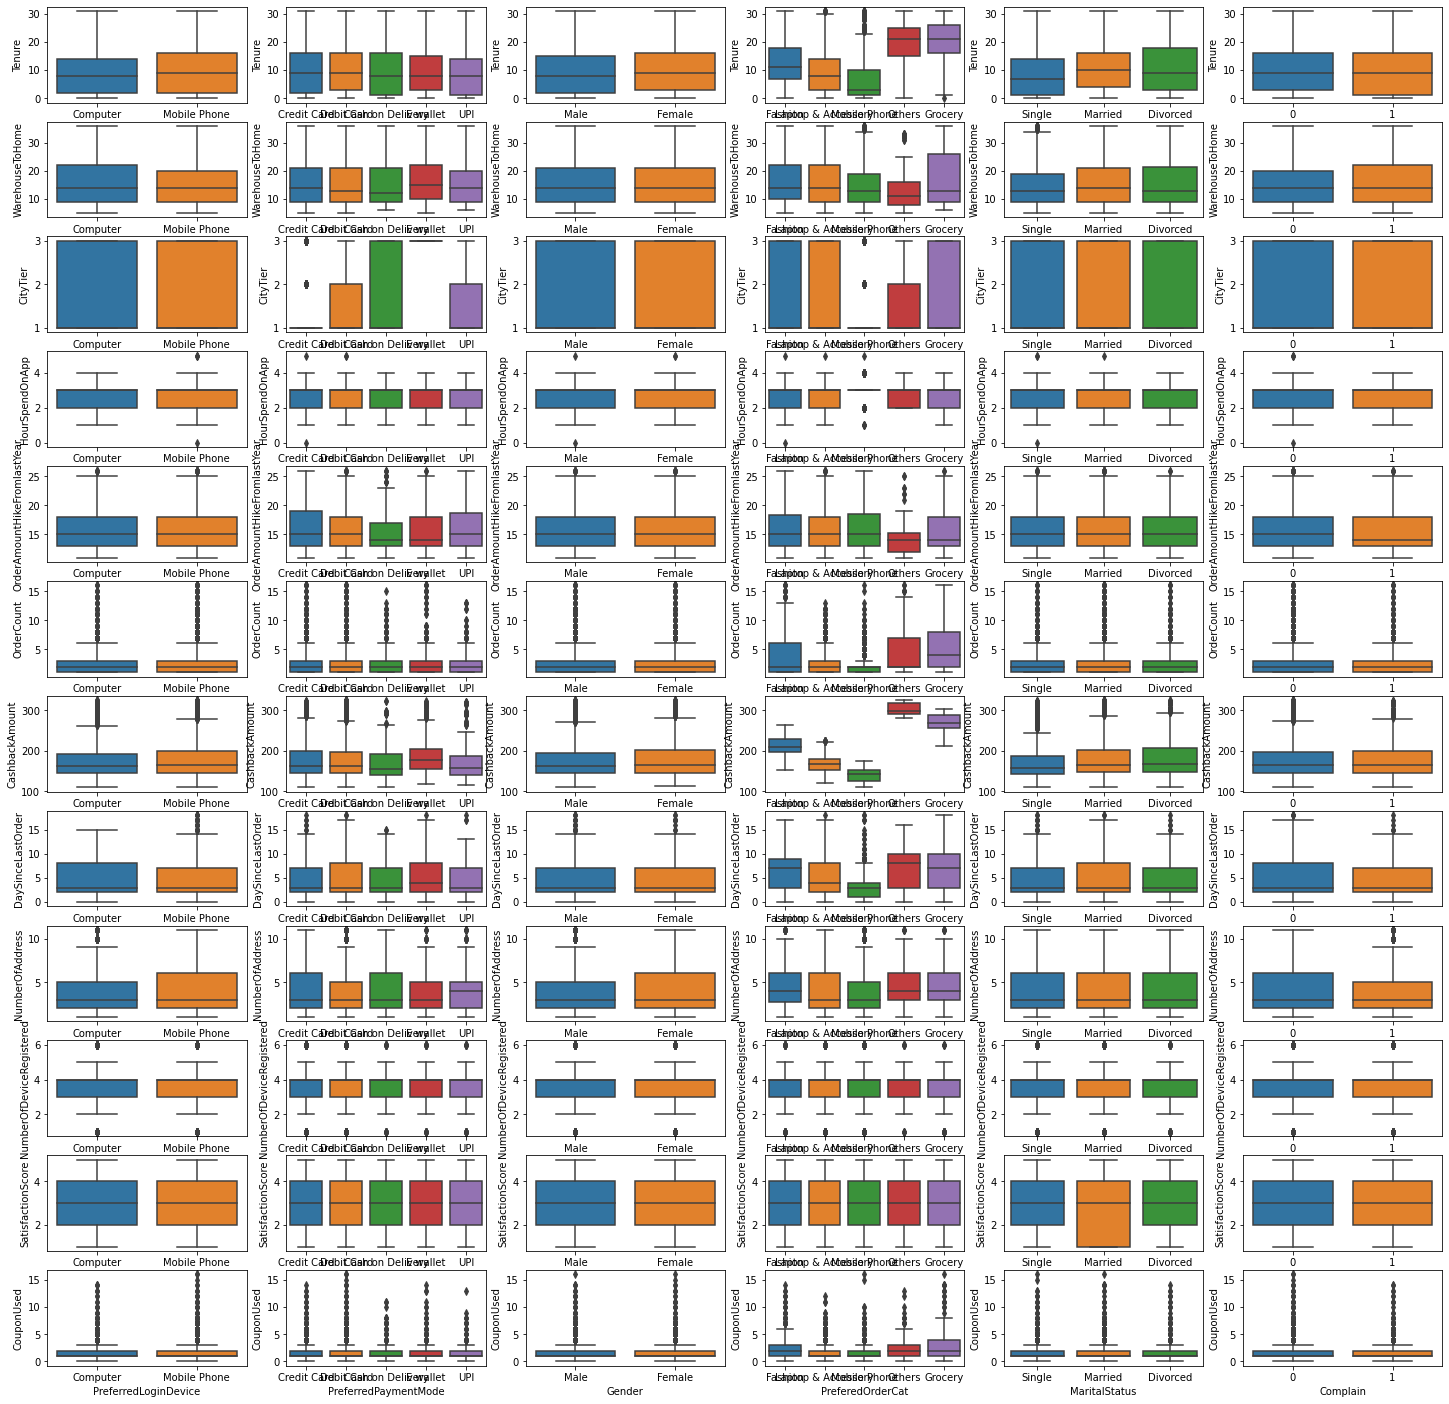

In [265]:
# Check correlation between features
# Numerical - Categorical
# Group by categorical column and aggregate values from numerical column as list
grouped_data = X_train_filter.loc[:,['Complain','SatisfactionScore']].dropna().groupby('Complain')['SatisfactionScore'].apply(list).reset_index()

# Perform Kruskal-Wallis test (H0: No significant difference between group medians)
groups = [grouped_data.loc[i]['SatisfactionScore'] for i in range(len(grouped_data))]
kw_statistic, p_value = kruskal(*groups)

# Print results
print("Kruskal-Wallis Test:")
print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: The groups have different medians.")
else:
    print("Fail to reject the null hypothesis: No significant difference between group medians.")

#visualize
fig, ax = plt.subplots(ncols = len(cat_col), nrows = len(num_col), figsize=(25,25))
for i in range(len(num_col)):
    for j in range(len(cat_col)):
        sns.boxplot(ax = ax[i,j], data = X_train_filter, y=num_col[i], x=cat_col[j], showfliers = True)
        
        

Clear correlation observed between CashbackAmount and PreferedOrderCat, where CashbackAmount increasing from Mobile Phone < Laptop & Accessories < Fashion & Apparel < Others < Grocery

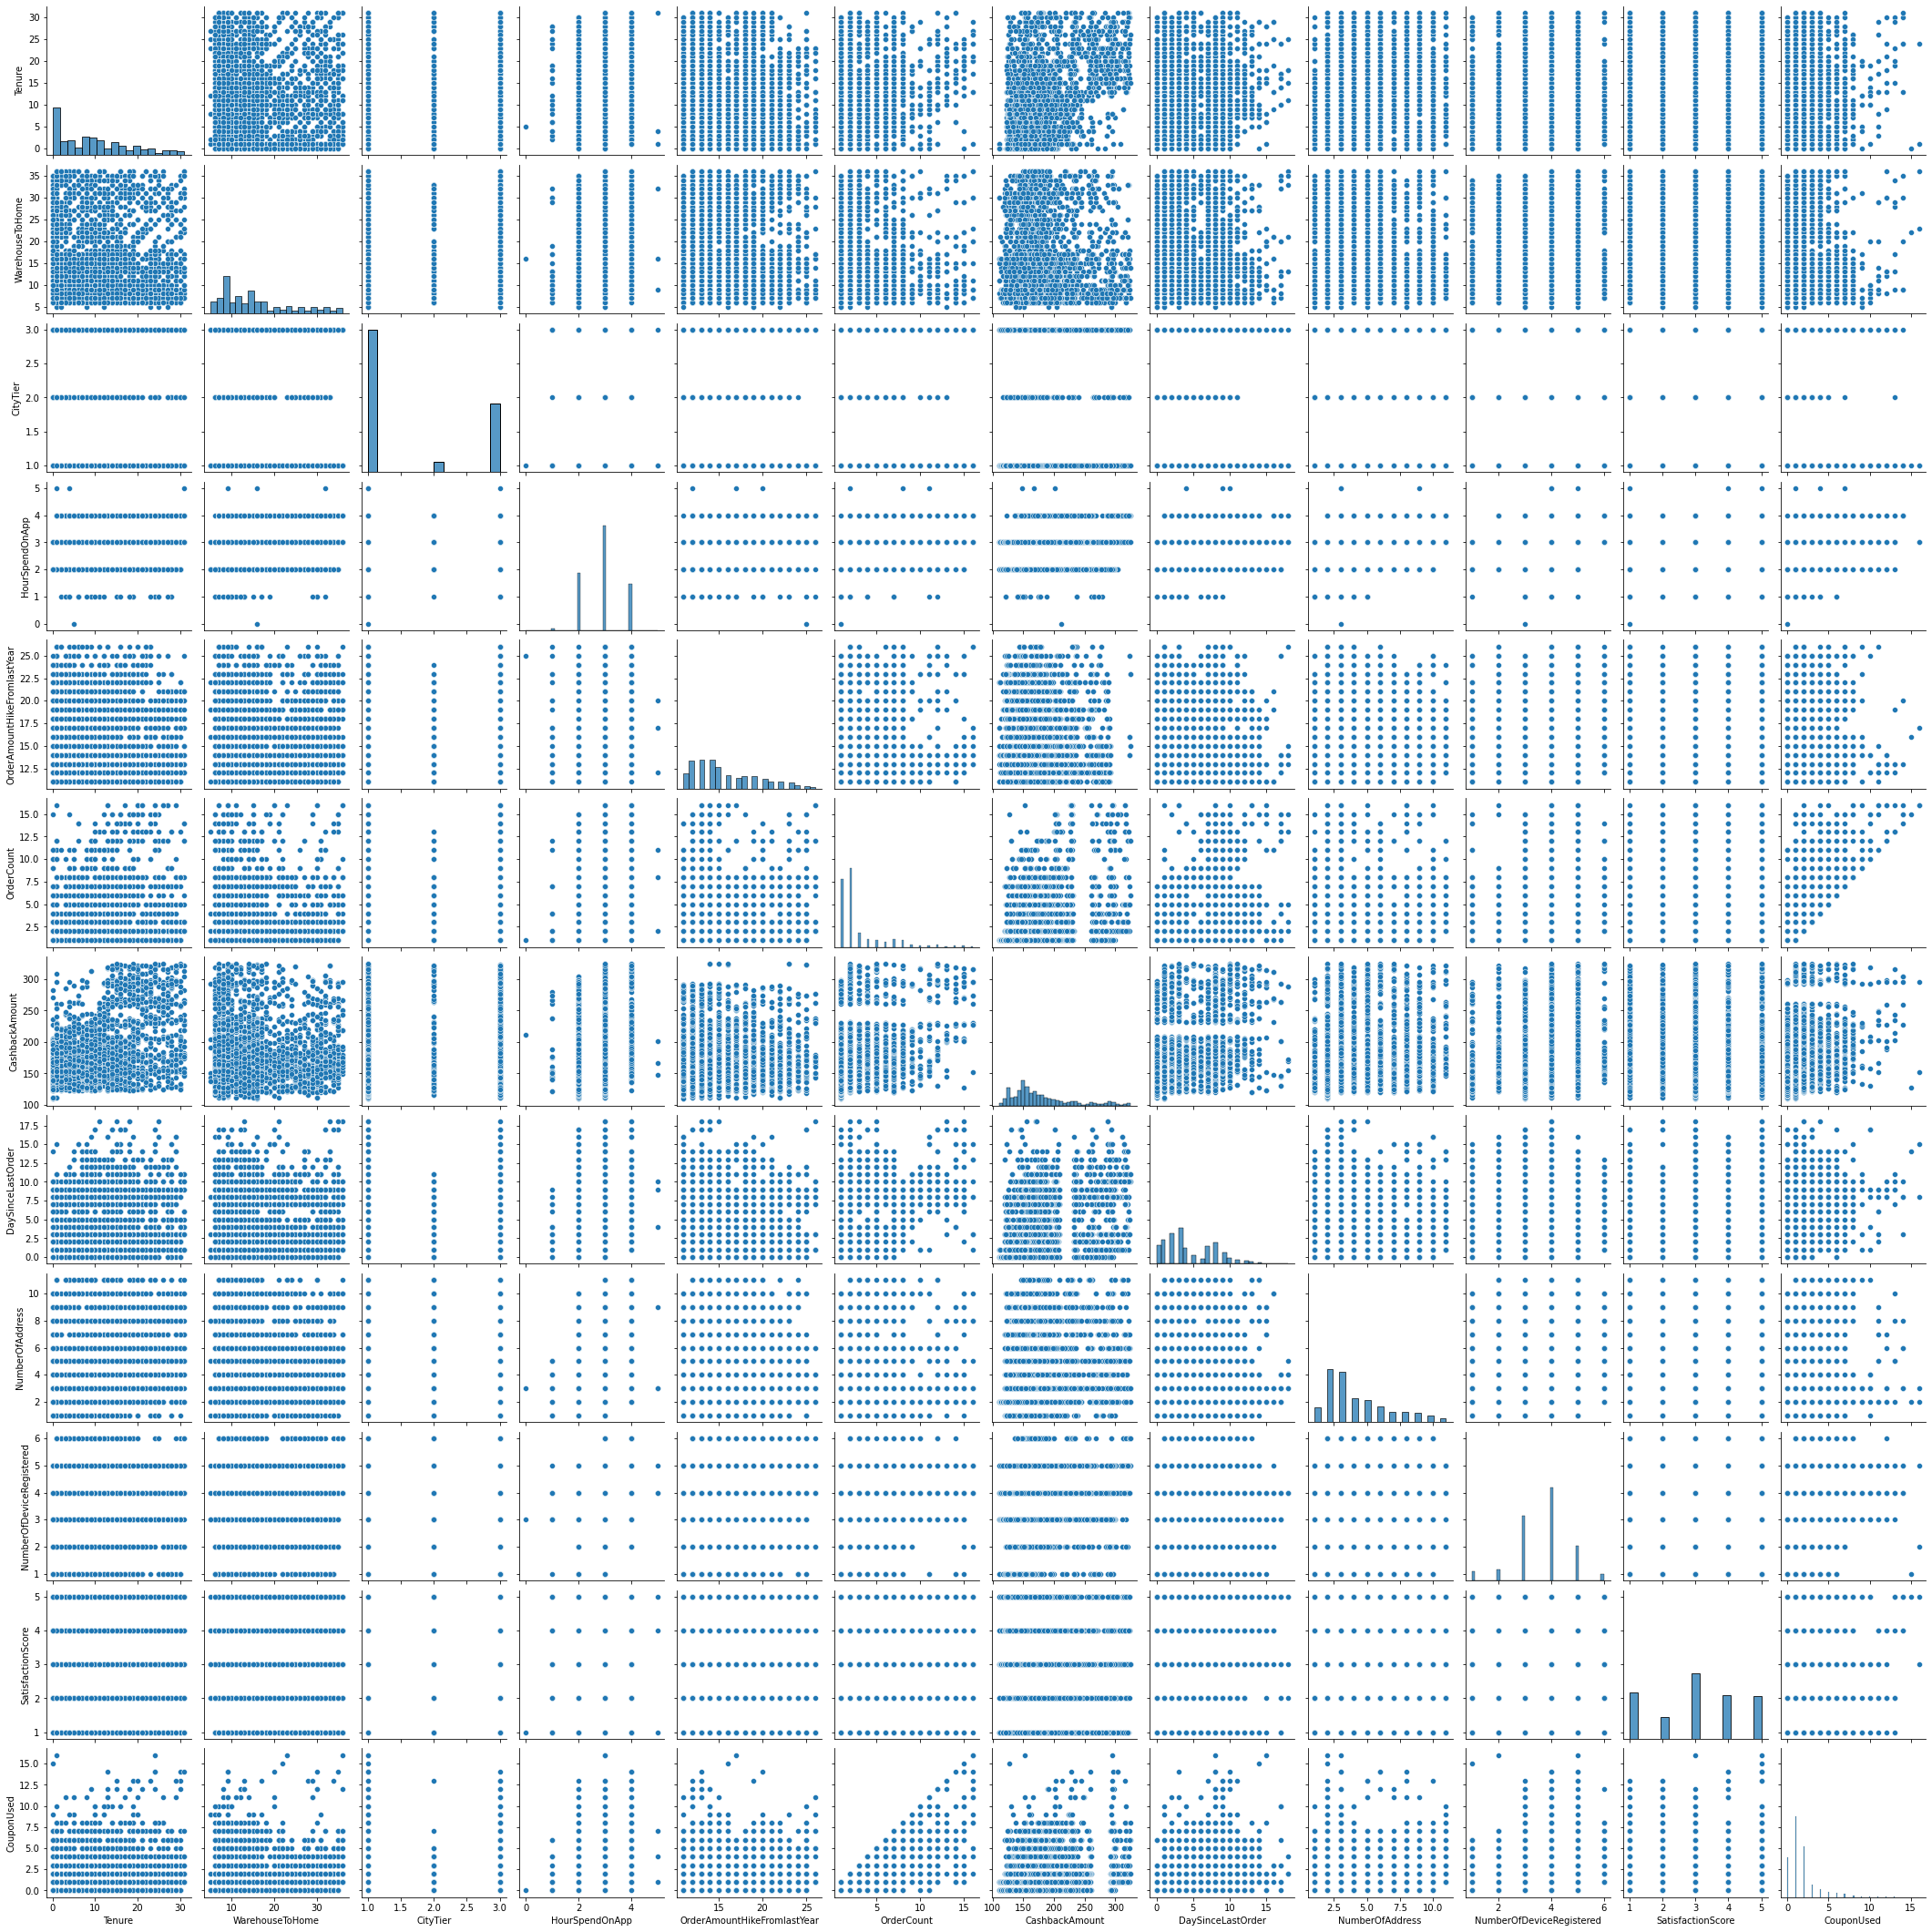

In [266]:
# Check correlation between features
# Numerical - Numerical
sns.pairplot(X_train_filter.loc[:,num_col])

From above, correlation was seen for OrderCount and CouponUsed. This makes sense as the number of coupon used can only be as many as the number of orders made. To normalize 'CouponUsed' and save as 'CouponToOrderRatio' in the pre-processing.



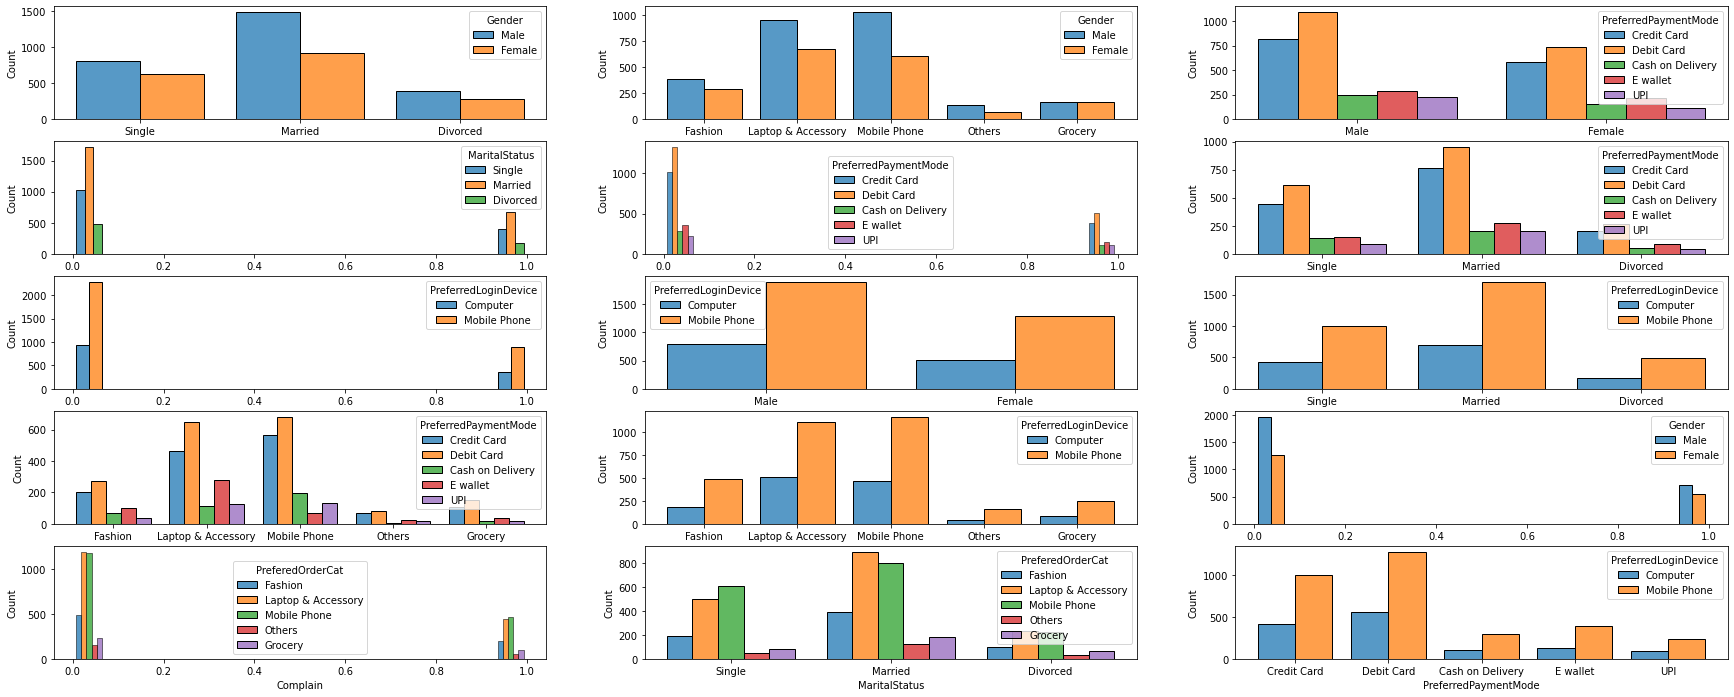

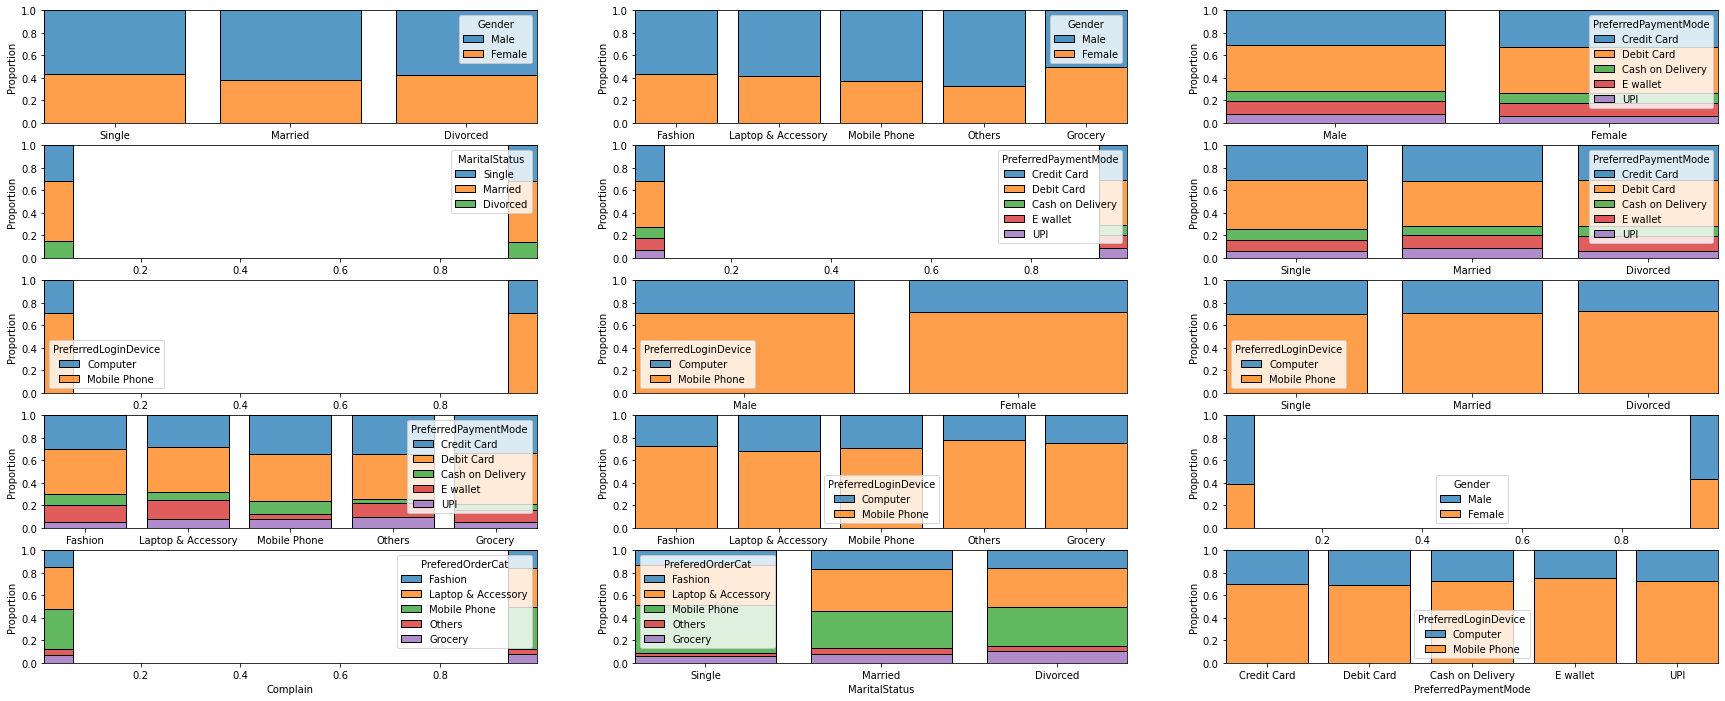

In [290]:
# Check correlation between features
# Categorical - Categorical

#Get unique pairs of categorical columns
def unique_combi(input_list):
    """
    Input: list with unique members
    Output: list of tuples containing unique pairwise combinations of input list members
    """
    return list(set(list(itertools.combinations(input_list, 2))))

#Visualize correlation between categorical features using bar chart
def bar_cat(X,multiple="dodge", stat = 'count'):
    """
    Input: dataframe containing feature columns to be plotted
    Output: display bar charts with frequency of feature b split by feature a from (a,b) pair 
    """
    pair = unique_combi(X.columns.to_list())
    fig, ax = plt.subplots(ncols = 3, nrows = math.ceil(len(pair)/3), figsize=(30,12))
    for x in range(len(pair)):
        df = pd.concat([X[[pair[x][0]]],X[[pair[x][1]]]], axis=1) # concat pair of columns in tuple i to dataframe df
        i = math.floor(x/3); j = x % 3 #define subplot row and column index
        sns.histplot(ax = ax[i,j], data = df, x=df.columns[1] , hue=df.columns[0], multiple=multiple, stat=stat, shrink=.8)
    plt.show()
    
#bar chart by count
bar_cat(X_train_filter.loc[:,cat_col],multiple="dodge", stat = "count")
#bar chart by proportion
bar_cat(X_train_filter.loc[:,cat_col],multiple="fill",stat = "proportion")

Correlation can be inferred by whether there's consistent the proportion of a categorical variable accross another categorical variables.

Correlations observed:
- PreferredOrderCat and Gender: higher Female/Male ratio for Grocery orders relative to other categories
- PreferredOrderCat and PreferredPaymentMode: higher Cash on Delivery usage relative to E wallet for MobilePhone orders relative to other categories

## Data Preprocessing

Data was preprocessed before training model according to findings from data quality check and EDA
To create pipeline for each processing to see which one works best
1. Outlier removal (done)
2. Missing data imputation
3. Class rebalancing
4. Feature selection/ engineering

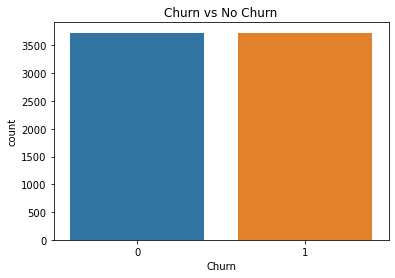

Dimension of final data:
X_train_final: (7460, 14),y_train_final: (7460,)
X_test_final: (1126, 14),  y_test_final: (1126,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7460 entries, 0 to 7459
Data columns (total 14 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   onehotencoder__PreferredPaymentMode_Credit Card     7460 non-null   float64
 1   onehotencoder__PreferredPaymentMode_Debit Card      7460 non-null   float64
 2   onehotencoder__PreferredPaymentMode_E wallet        7460 non-null   float64
 3   onehotencoder__PreferredPaymentMode_UPI             7460 non-null   float64
 4   onehotencoder__PreferedOrderCat_Grocery             7460 non-null   float64
 5   onehotencoder__PreferedOrderCat_Laptop & Accessory  7460 non-null   float64
 6   onehotencoder__PreferedOrderCat_Mobile Phone        7460 non-null   float64
 7   onehotencoder__PreferedOrderCat_Othe

In [326]:
# Simple imputer (median)
def impute_features_simple(X_train,X_test,feature_columns):
    imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
    for feature in feature_columns:
        X_train[feature] = imputer.fit_transform(X_train[feature].values.reshape(-1,1))[:,0]
        X_test[feature] = imputer.transform(X_test[feature].values.reshape(-1,1))[:,0]
    return X_train, X_test

X_train_final, X_test_final = impute_features_simple(X_train_filter,X_test,df_missing.columns.to_list())

"""
based on above EDA, it was found that features that have strong correlation to churn are as follows:
'PreferredPaymentMode','PreferedOrderCat','MaritalStatus','Complain','Tenure','CashbackAmount','DaySinceLastOrder'

while correlation was seen between following features:
('PreferredOrderCat','Gender'),('PreferredOrderCat','PreferredPaymentMode'),('CashbackAmount','PreferedOrderCat')

"""

#Select features with correlation to churn
feature_selected = ['PreferredPaymentMode','PreferedOrderCat','MaritalStatus','Complain','Tenure','CashbackAmount','DaySinceLastOrder']
X_train_final = X_train_final.loc[:,feature_selected]
X_test_final = X_test_final.loc[:,feature_selected]

#get numerical and categorical columns from feature_selected
cat_selected = X_train_final.loc[:,X_train_final.dtypes == 'object'].columns.to_list()
num_selected = list(set(X_train_final.columns.to_list()) - set(cat_selected))

#Categorical feature encoding
enc = OneHotEncoder(
    handle_unknown='error',
    drop='first'
)
transformer = make_column_transformer(
    (enc, cat_selected),
    remainder='passthrough'
)
transformed = transformer.fit_transform(X_train_final)
X_train_final = pd.DataFrame(
    transformed, 
    columns = transformer.get_feature_names_out()
)
transformed_test = transformer.transform(X_test_final)
X_test_final = pd.DataFrame(
    transformed_test, 
    columns = transformer.get_feature_names_out()
)


#Oversampling
X_train_final, y_train_final = SMOTE(random_state=42).fit_resample(X_train_final, y_train_filter)


#Check new y_train ratio
sns.countplot(x='Churn',data=y_train_final)
plt.title('Churn vs No Churn')
plt.show()

y_train_final = y_train_final.to_numpy().flatten()
y_test_final = y_test[:].to_numpy().flatten()

#Check dimension
print('Dimension of final data:') 
print(f'X_train_final: {X_train_final.shape},y_train_final: {y_train_final.shape}')
print(f'X_test_final: {X_test_final.shape},  y_test_final: {y_test_final.shape}')

X_train_final.info()


## Model Training

### Random Forest

In [328]:
#Try RandomForestClassifier() with default hyperparameters
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=1
)

# Calculate cross validation score for the default model

kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

f1 = cross_val_score(rf, X_train_final, y_train_final, scoring='f1', cv=kf).mean()

print(f"CV F1 score (default rf): {f1}")

CV F1 score (default rf): 0.8844811280820121


In [340]:
#TUNE RF HYPERPARAMETER

#Maximum features per tree
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [4, 8, 12, 16, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 8]
# Create the random grid
param2_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Instantiate cv
rf2 = RandomForestClassifier(n_estimators =  500) #from 1st tuning
rf2_cv = RandomizedSearchCV(rf2, param2_grid, scoring='f1', cv=kf, n_iter = 100, verbose=3, random_state=42, n_jobs = -1)

# Fit to the training data
rf2_cv.fit(X_train_final, y_train_final)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_estimators=500),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [2, 4, 6, 8],
                                        'min_samples_split': [4, 8, 12, 16,
                                                              20]},
                   random_state=42, scoring='f1', verbose=3)

In [342]:
#Print tuned rf parameter and score
print("Tuned rf paramaters: {}".format(rf2_cv.best_params_))
print("Tuned rf score: {}".format(rf2_cv.best_score_))

Tuned rf paramaters: {'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 60}
Tuned rf score: 0.948272153475435


In [349]:
#Tune again with narrower range using GridSearchCV
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(55, 65, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [3,4,5,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3]
# Create the random grid
param3_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Instantiate cv
rf3 = RandomForestClassifier(max_features = 'log2', n_estimators =  500) #from 1st/2nd tuning
rf3_cv = GridSearchCV(rf3, param3_grid, scoring='f1', cv=kf, verbose=3, n_jobs = -1)

# Fit to the training data
rf3_cv.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(max_features='log2',
                                              n_estimators=500),
             n_jobs=-1,
             param_grid={'max_depth': [55, 57, 59, 61, 63, 65],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [3, 4, 5, 6]},
             scoring='f1', verbose=3)

[CV 1/5] END max_depth=55, min_samples_leaf=2, min_samples_split=3;, score=0.950 total time=   4.4s
[CV 4/5] END max_depth=55, min_samples_leaf=2, min_samples_split=5;, score=0.941 total time=   4.4s
[CV 1/5] END max_depth=55, min_samples_leaf=3, min_samples_split=3;, score=0.931 total time=   4.2s
[CV 2/5] END max_depth=55, min_samples_leaf=3, min_samples_split=4;, score=0.939 total time=   4.1s
[CV 4/5] END max_depth=55, min_samples_leaf=3, min_samples_split=5;, score=0.935 total time=   4.2s
[CV 1/5] END max_depth=57, min_samples_leaf=2, min_samples_split=3;, score=0.949 total time=   4.6s
[CV 1/5] END max_depth=57, min_samples_leaf=2, min_samples_split=5;, score=0.949 total time=   4.3s
[CV 4/5] END max_depth=57, min_samples_leaf=2, min_samples_split=6;, score=0.936 total time=   4.3s
[CV 3/5] END max_depth=57, min_samples_leaf=3, min_samples_split=4;, score=0.948 total time=   4.4s
[CV 4/5] END max_depth=57, min_samples_leaf=3, min_samples_split=5;, score=0.933 total time=   4.7s


[CV 1/5] END max_depth=55, min_samples_leaf=2, min_samples_split=4;, score=0.947 total time=   4.4s
[CV 3/5] END max_depth=55, min_samples_leaf=2, min_samples_split=5;, score=0.947 total time=   4.4s
[CV 4/5] END max_depth=55, min_samples_leaf=3, min_samples_split=3;, score=0.933 total time=   4.3s
[CV 2/5] END max_depth=55, min_samples_leaf=3, min_samples_split=5;, score=0.938 total time=   4.1s
[CV 4/5] END max_depth=55, min_samples_leaf=3, min_samples_split=6;, score=0.935 total time=   4.2s
[CV 1/5] END max_depth=57, min_samples_leaf=2, min_samples_split=4;, score=0.947 total time=   4.7s
[CV 5/5] END max_depth=57, min_samples_leaf=2, min_samples_split=5;, score=0.950 total time=   4.3s
[CV 2/5] END max_depth=57, min_samples_leaf=3, min_samples_split=3;, score=0.939 total time=   4.2s
[CV 5/5] END max_depth=57, min_samples_leaf=3, min_samples_split=4;, score=0.944 total time=   4.5s
[CV 2/5] END max_depth=57, min_samples_leaf=3, min_samples_split=6;, score=0.938 total time=   4.7s


In [354]:
display(pd.DataFrame(rf3_cv.cv_results_).sort_values('rank_test_score').head())
#Print tuned rf parameter and score
print("Tuned rf paramaters: {}".format(rf3_cv.best_params_))
print("Tuned rf score: {}".format(rf3_cv.best_score_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,4.905933,0.113889,0.314993,0.024311,61,2,4,"{'max_depth': 61, 'min_samples_leaf': 2, 'min_samples_split': 4}",0.948915,0.944850,0.949391,0.946267,0.953186,0.948522,0.002872,1
1,4.151604,0.019745,0.248283,0.006066,55,2,4,"{'max_depth': 55, 'min_samples_leaf': 2, 'min_samples_split': 4}",0.946927,0.943371,0.949326,0.946191,0.953866,0.947937,0.003521,2
8,4.336766,0.036896,0.266319,0.002672,57,2,3,"{'max_depth': 57, 'min_samples_leaf': 2, 'min_samples_split': 3}",0.948844,0.945260,0.950546,0.942080,0.952010,0.947748,0.003620,3
40,4.675099,0.061265,0.305512,0.015066,65,2,3,"{'max_depth': 65, 'min_samples_leaf': 2, 'min_samples_split': 3}",0.947662,0.943220,0.949936,0.944134,0.953247,0.947640,0.003702,4
9,4.266779,0.138777,0.252715,0.002620,57,2,4,"{'max_depth': 57, 'min_samples_leaf': 2, 'min_samples_split': 4}",0.946853,0.943296,0.949261,0.944794,0.953986,0.947638,0.003755,5


Tuned rf paramaters: {'max_depth': 61, 'min_samples_leaf': 2, 'min_samples_split': 4}
Tuned rf score: 0.9485219537817773


### AdaBoostClassifier

In [357]:
#Try AdaBoostClassifier() with default hyperparameters
abc = AdaBoostClassifier()

# Calculate cross validation score for the default model

f1_abc = cross_val_score(abc, X_train_final, y_train_final, scoring='f1', cv=kf).mean()

print(f"CV F1 score (default AdaBoost): {f1_abc}")

CV F1 score (default AdaBoost): 0.9007109639546641


In [389]:
#TUNE AdaBoost HYPERPARAMETER

#Maximum number of estimators
n_estimators = [10, 50, 100, 500, 1000, 5000]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]

# Create the random grid
abc2_grid = {'n_estimators': n_estimators,
            'learning_rate':learning_rate}

# Instantiate cv
abc2 = AdaBoostClassifier(n_estimators =  n_estimators, learning_rate=learning_rate)
abc2_cv = GridSearchCV(abc2, abc2_grid, scoring='f1', cv=kf, verbose=3, n_jobs = -1)

# Fit to the training data
abc2_cv.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(learning_rate=[0.0001, 0.001, 0.01,
                                                         0.1, 1.0],
                                          n_estimators=[10, 50, 100, 500, 1000,
                                                        5000]),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [10, 50, 100, 500, 1000, 5000]},
             scoring='f1', verbose=3)

In [391]:
# show scores
abc2_score = pd.DataFrame(abc2_cv.cv_results_)
display(abc2_score.sort_values('rank_test_score').head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,44.251601,0.235458,2.573825,0.153462,0.1,5000,"{'learning_rate': 0.1, 'n_estimators': 5000}",0.885755,0.892979,0.915100,0.899367,0.910408,0.900722,0.010829,1
25,0.444627,0.007111,0.033093,0.002411,1.0,50,"{'learning_rate': 1.0, 'n_estimators': 50}",0.881616,0.898861,0.911990,0.899861,0.911227,0.900711,0.011014,2
27,4.449235,0.034522,0.270712,0.005798,1.0,500,"{'learning_rate': 1.0, 'n_estimators': 500}",0.888889,0.891468,0.912621,0.898449,0.910053,0.900296,0.009577,3
26,0.875118,0.010248,0.057862,0.002527,1.0,100,"{'learning_rate': 1.0, 'n_estimators': 100}",0.887018,0.895805,0.903351,0.899930,0.914435,0.900108,0.009008,4
28,8.857115,0.048588,0.539918,0.012729,1.0,1000,"{'learning_rate': 1.0, 'n_estimators': 1000}",0.885130,0.894053,0.909326,0.900709,0.908367,0.899517,0.009086,5


In [392]:
#TUNE AdaBoost HYPERPARAMETER #2 - tune base estimator (DecisionTreeClassifier(max_depth=1))

#Base Estimator
base_estimator= [DecisionTreeClassifier(max_depth=x) for x in range(1, 11)]

# Create the random grid
abc3_grid = {'base_estimator': base_estimator}


# Instantiate cv
abc3 = AdaBoostClassifier(n_estimators =  5000, learning_rate = 0.1, base_estimator=base_estimator)
abc3_cv = GridSearchCV(abc3, abc3_grid, scoring='f1', cv=kf, verbose=2, n_jobs = -1)

# Fit to the training data
abc3_cv.fit(X_train_final, y_train_final)

# Rank test result
display(pd.DataFrame(abc3_cv.cv_results_).sort_values('rank_test_score').head())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,100.603145,3.417756,2.931242,0.046591,DecisionTreeClassifier(max_depth=6),{'base_estimator': DecisionTreeClassifier(max_depth=6)},0.963432,0.953271,0.960822,0.956944,0.972833,0.961460,0.006650,1
4,99.373025,4.349351,2.894207,0.108094,DecisionTreeClassifier(max_depth=5),{'base_estimator': DecisionTreeClassifier(max_depth=5)},0.961458,0.955764,0.962107,0.956098,0.970246,0.961134,0.005259,2
9,101.453001,12.150866,2.021559,0.423579,DecisionTreeClassifier(max_depth=10),{'base_estimator': DecisionTreeClassifier(max_depth=10)},0.961512,0.955422,0.956969,0.958275,0.970836,0.960603,0.005496,3
2,78.029256,0.141847,2.739613,0.084948,DecisionTreeClassifier(max_depth=3),{'base_estimator': DecisionTreeClassifier(max_depth=3)},0.963483,0.949900,0.962348,0.954039,0.971391,0.960232,0.007546,4
7,118.725106,3.424154,3.307693,0.406929,DecisionTreeClassifier(max_depth=8),{'base_estimator': DecisionTreeClassifier(max_depth=8)},0.963636,0.952824,0.959744,0.955370,0.967617,0.959838,0.005369,5


<AxesSubplot:xlabel='params', ylabel='mean_test_score'>

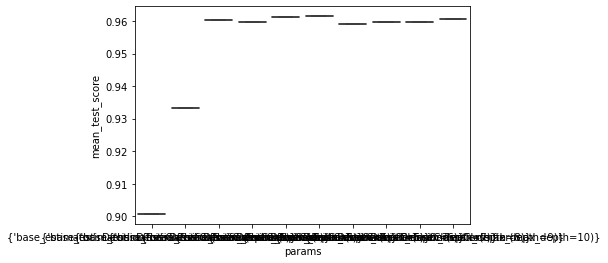

[CV 2/5] END learning_rate=0.0001, n_estimators=50;, score=0.767 total time=   0.5s
[CV 5/5] END learning_rate=0.0001, n_estimators=100;, score=0.762 total time=   0.9s
[CV 3/5] END learning_rate=0.0001, n_estimators=1000;, score=0.772 total time=   9.2s
[CV 5/5] END learning_rate=0.0001, n_estimators=5000;, score=0.762 total time=  46.6s
[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=0.763 total time=   0.9s
[CV 2/5] END learning_rate=0.01, n_estimators=500;, score=0.850 total time=   4.6s
[CV 5/5] END learning_rate=0.01, n_estimators=500;, score=0.846 total time=   4.7s
[CV 3/5] END learning_rate=0.01, n_estimators=1000;, score=0.865 total time=   9.3s
[CV 5/5] END learning_rate=0.01, n_estimators=1000;, score=0.868 total time=   9.3s
[CV 4/5] END learning_rate=0.01, n_estimators=5000;, score=0.887 total time=  46.9s
[CV 2/5] END learning_rate=1.0, n_estimators=100;, score=0.896 total time=   0.9s
[CV 5/5] END learning_rate=1.0, n_estimators=100;, score=0.914 total time=  

[CV 5/5] END learning_rate=0.0001, n_estimators=10;, score=0.762 total time=   0.1s
[CV 2/5] END learning_rate=0.0001, n_estimators=100;, score=0.767 total time=   0.9s
[CV 5/5] END learning_rate=0.0001, n_estimators=500;, score=0.762 total time=   4.6s
[CV 3/5] END learning_rate=0.0001, n_estimators=5000;, score=0.772 total time=  46.8s
[CV 5/5] END learning_rate=0.001, n_estimators=5000;, score=0.846 total time=  46.9s
[CV 3/5] END learning_rate=0.1, n_estimators=500;, score=0.905 total time=   4.6s
[CV 1/5] END learning_rate=0.1, n_estimators=1000;, score=0.878 total time=   9.7s
[CV 4/5] END learning_rate=0.1, n_estimators=1000;, score=0.896 total time=   9.4s
[CV 2/5] END learning_rate=0.1, n_estimators=5000;, score=0.893 total time=  46.9s
[CV 5/5] END learning_rate=1.0, n_estimators=5000;, score=0.907 total time=  35.8s
[CV] END .base_estimator=DecisionTreeClassifier(max_depth=2); total time= 1.1min
[CV] END .base_estimator=DecisionTreeClassifier(max_depth=3); total time= 1.3min

In [393]:
abc3_score = pd.DataFrame(abc3_cv.cv_results_)
abc3_score['params']=abc3_score['params'].astype('string')
sns.boxplot(data=abc3_score, x="params", y="mean_test_score")

### Gradient Boosting

In [408]:
#Try GradientBoostingClassifier() with default hyperparameters
gbc = GradientBoostingClassifier(random_state=1)

f1_gbc = cross_val_score(gbc, X_train_final, y_train_final, scoring='f1', cv=kf).mean()

print(f"CV F1 score (default Gradient Boosting): {f1_gbc}")

CV F1 score (default Gradient Boosting): 0.9133122021503413


In [399]:
#TUNE Gradient Boosting HYPERPARAMETER

#Maximum number of estimators
n_estimators = [10, 50, 100, 500, 1000]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]
max_depth = [1,2,4,6,8,10]

# Create the random grid
gbc2_grid = {'n_estimators': n_estimators,
            'learning_rate':learning_rate,
            'max_depth':max_depth
            }

# Instantiate cv
gbc2 = GradientBoostingClassifier()
gbc2_cv = RandomizedSearchCV(gbc2, gbc2_grid, scoring='f1', cv=kf, n_iter = 50, verbose=2, n_jobs = -1)



# Fit to the training data
gbc2_cv.fit(X_train_final, y_train_final)

# Rank test result
display(pd.DataFrame(gbc2_cv.cv_results_).sort_values('rank_test_score').head())

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,37.587373,0.313862,0.135935,0.001620,1000,8,0.1,"{'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.1}",0.965566,0.961487,0.966134,0.954830,0.975958,0.964795,0.006888,1
36,45.752348,0.856865,0.177093,0.024327,1000,10,0.1,"{'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1}",0.964211,0.964690,0.964149,0.952050,0.976654,0.964351,0.007783,2
41,4.670153,0.361483,0.019988,0.004611,100,10,1.0,"{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 1.0}",0.960784,0.960106,0.960972,0.950865,0.975958,0.961737,0.008057,3
9,2.478878,0.051145,0.028664,0.026182,100,6,1.0,"{'n_estimators': 100, 'max_depth': 6, 'learning_rate': 1.0}",0.962807,0.953333,0.960922,0.948540,0.968367,0.958794,0.007032,4
35,21.927499,1.485597,0.092523,0.005227,1000,6,1.0,"{'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 1.0}",0.963585,0.954667,0.961588,0.948468,0.964447,0.958551,0.006101,5


[CV] END learning_rate=0.0001, max_depth=6, n_estimators=1000; total time=  25.5s
[CV] END learning_rate=0.0001, max_depth=6, n_estimators=1000; total time=  22.8s
[CV] END .learning_rate=0.001, max_depth=10, n_estimators=10; total time=   0.4s
[CV] END ...learning_rate=1.0, max_depth=6, n_estimators=100; total time=   2.5s
[CV] END ...learning_rate=1.0, max_depth=6, n_estimators=100; total time=   2.6s
[CV] END ..learning_rate=1.0, max_depth=2, n_estimators=1000; total time=   9.4s
[CV] END ...learning_rate=10, max_depth=4, n_estimators=1000; total time=  15.7s
[CV] END .learning_rate=0.0001, max_depth=8, n_estimators=50; total time=   1.6s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=1000; total time=   5.4s
[CV] END ..learning_rate=0.1, max_depth=1, n_estimators=1000; total time=   5.3s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   9.6s
[CV] END ...learning_rate=10, max_depth=6, n_estimators=1000; total time=  25.8s
[CV] END .learning_rate=0.

[CV] END learning_rate=0.0001, max_depth=10, n_estimators=1000; total time=  43.9s
[CV] END ....learning_rate=10, max_depth=8, n_estimators=100; total time=   3.5s
[CV] END ...learning_rate=1.0, max_depth=4, n_estimators=500; total time=   8.1s
[CV] END ....learning_rate=1.0, max_depth=6, n_estimators=50; total time=   1.2s
[CV] END ....learning_rate=1.0, max_depth=6, n_estimators=50; total time=   1.3s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=100; total time=   0.6s
[CV] END .learning_rate=0.001, max_depth=1, n_estimators=500; total time=   3.2s
[CV] END ...learning_rate=10, max_depth=4, n_estimators=1000; total time=  15.7s
[CV] END learning_rate=0.0001, max_depth=8, n_estimators=1000; total time=  34.3s
[CV] END ...learning_rate=1.0, max_depth=1, n_estimators=500; total time=   2.8s
[CV] END ...learning_rate=1.0, max_depth=1, n_estimators=500; total time=   2.5s
[CV] END ....learning_rate=10, max_depth=10, n_estimators=50; total time=   2.3s
[CV] END ....learning_rat

In [400]:
#TUNE Gradient Boosting HYPERPARAMETER#2

#Maximum number of estimators
min_samples_split = [2,4,6,8,10,20,30,50]
min_samples_leaf = [1,3,5,7,9]

# Create the random grid
gbc3_grid = {'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf
            }

# Instantiate cv
gbc3 = GradientBoostingClassifier(n_estimators=1000, max_depth=8, learning_rate=0.1)
gbc3_cv = GridSearchCV(gbc3, gbc3_grid, scoring='f1', cv=kf, verbose=2, n_jobs = -1)


# Fit to the training data
gbc3_cv.fit(X_train_final, y_train_final)

# Rank test result
display(pd.DataFrame(gbc3_cv.cv_results_).sort_values('rank_test_score').head())

Fitting 5 folds for each of 40 candidates, totalling 200 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,36.138620,1.138699,0.147163,0.010143,1,4,"{'min_samples_leaf': 1, 'min_samples_split': 4}",0.968332,0.959947,0.969930,0.952646,0.976654,0.965502,0.008344,1
14,30.943463,0.912807,0.131638,0.007287,3,30,"{'min_samples_leaf': 3, 'min_samples_split': 30}",0.965614,0.960053,0.966047,0.955494,0.977287,0.964899,0.007311,2
4,34.524275,1.606854,0.160234,0.027032,1,10,"{'min_samples_leaf': 1, 'min_samples_split': 10}",0.966878,0.959947,0.967287,0.954230,0.975990,0.964866,0.007362,3
20,35.258915,1.489687,0.125892,0.007547,5,10,"{'min_samples_leaf': 5, 'min_samples_split': 10}",0.970547,0.957333,0.966624,0.951983,0.977287,0.964755,0.009081,4
5,35.866678,0.161932,0.151720,0.005447,1,20,"{'min_samples_leaf': 1, 'min_samples_split': 20}",0.965566,0.961975,0.967329,0.951321,0.976654,0.964569,0.008208,5


[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=  37.7s
[CV] END ............min_samples_leaf=1, min_samples_split=6; total time=  33.9s
[CV] END ............min_samples_leaf=1, min_samples_split=8; total time=  33.8s
[CV] END ...........min_samples_leaf=1, min_samples_split=20; total time=  36.1s
[CV] END ...........min_samples_leaf=1, min_samples_split=30; total time=  32.4s
[CV] END ............min_samples_leaf=3, min_samples_split=2; total time=  40.7s
[CV] END ............min_samples_leaf=3, min_samples_split=6; total time=  36.0s
[CV] END ............min_samples_leaf=3, min_samples_split=8; total time=  33.4s
[CV] END ...........min_samples_leaf=3, min_samples_split=20; total time=  32.9s
[CV] END ...........min_samples_leaf=3, min_samples_split=30; total time=  30.4s
[CV] END ............min_samples_leaf=5, min_samples_split=4; total time=  32.7s
[CV] END ............min_samples_leaf=5, min_samples_split=6; total time=  32.7s
[CV] END ...........min_samp

[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  37.0s
[CV] END ............min_samples_leaf=1, min_samples_split=4; total time=  35.0s
[CV] END ...........min_samples_leaf=1, min_samples_split=10; total time=  34.1s
[CV] END ...........min_samples_leaf=1, min_samples_split=20; total time=  36.1s
[CV] END ...........min_samples_leaf=1, min_samples_split=50; total time=  31.3s
[CV] END ............min_samples_leaf=3, min_samples_split=2; total time=  40.7s
[CV] END ............min_samples_leaf=3, min_samples_split=4; total time=  36.5s
[CV] END ............min_samples_leaf=3, min_samples_split=8; total time=  33.6s
[CV] END ...........min_samples_leaf=3, min_samples_split=20; total time=  32.8s
[CV] END ...........min_samples_leaf=3, min_samples_split=30; total time=  30.5s
[CV] END ............min_samples_leaf=5, min_samples_split=4; total time=  31.1s
[CV] END ............min_samples_leaf=5, min_samples_split=6; total time=  33.8s
[CV] END ...........min_samp

### XGBoost

In [409]:
xgbc = XGBClassifier()

f1_xgbc = cross_val_score(xgbc, X_train_final, y_train_final, scoring='f1', cv=kf).mean()

print(f"CV F1 score (default XGBoost): {f1_xgbc}")

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:08] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:33:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV F1 score (default XGBoost): 0.9504351115512026


In [411]:
#TUNE XGBoost HYPERPARAMETER

#Maximum number of estimators
max_depth = [1,2,3,4,5,6,7,8,9,10]
min_child_weight = [1,3,5]

# Create the random grid
xgbc2_grid = {
 'max_depth':max_depth,
 'min_child_weight':min_child_weight
}

# Instantiate cv
xgbc2 = XGBClassifier()
xgbc2_cv = GridSearchCV(xgbc2, xgbc2_grid, scoring='f1', cv=kf, verbose=2, n_jobs = -1)


# Fit to the training data
xgbc2_cv.fit(X_train_final, y_train_final)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[17:00:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weigh...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_child_weight': [1, 3, 5]},
             scoring='f1', verbose=2)

In [412]:
# Rank test result
display(pd.DataFrame(xgbc2_cv.cv_results_).sort_values('rank_test_score').head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,6.778322,0.184821,0.008105,0.000952,10,1,"{'max_depth': 10, 'min_child_weight': 1}",0.960452,0.954667,0.959693,0.952117,0.968791,0.959144,0.005736,1
21,5.591025,0.184202,0.007834,0.000980,8,1,"{'max_depth': 8, 'min_child_weight': 1}",0.955789,0.956696,0.954458,0.950592,0.972692,0.958045,0.007614,2
24,6.202603,0.247562,0.007848,0.000540,9,1,"{'max_depth': 9, 'min_child_weight': 1}",0.954930,0.954727,0.959027,0.946341,0.970798,0.957165,0.007968,3
28,6.137680,0.211306,0.007175,0.000919,10,3,"{'max_depth': 10, 'min_child_weight': 3}",0.951647,0.951495,0.955684,0.945455,0.966688,0.954194,0.007050,4
18,5.005562,0.082835,0.007541,0.000611,7,1,"{'max_depth': 7, 'min_child_weight': 1}",0.950315,0.947298,0.953787,0.950980,0.963589,0.953194,0.005592,5


[16:59:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=1, min_child_weight=1; total time=   0.9s
[16:59:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=1, min_child_weight=5; total time=   0.9s
[16:59:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

[16:59:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=1, min_child_weight=1; total time=   0.9s
[16:59:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=1, min_child_weight=3; total time=   0.9s
[16:59:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

[16:59:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=1, min_child_weight=1; total time=   0.9s
[16:59:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=1, min_child_weight=3; total time=   0.9s
[16:59:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

[16:59:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=1, min_child_weight=3; total time=   0.9s
[16:59:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=1, min_child_weight=5; total time=   0.9s
[16:59:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

[16:59:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=1, min_child_weight=3; total time=   0.9s
[16:59:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=2, min_child_weight=1; total time=   1.4s
[16:59:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

In [413]:
#TUNE XGBoost HYPERPARAMETER#2

#Maximum number of estimators
max_depth = [9,10,11]
min_child_weight = [1,2,3]

# Create the random grid
xgbc3_grid = {
 'max_depth':max_depth,
 'min_child_weight':min_child_weight
}

# Instantiate cv
xgbc3 = XGBClassifier()
xgbc3_cv = GridSearchCV(xgbc3, xgbc3_grid, scoring='f1', cv=kf, verbose=2, n_jobs = -1)


# Fit to the training data
xgbc3_cv.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[17:19:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'max_depth': [9, 10, 11],
                         'min_child_weight': [1, 2, 3]},
             scoring='f1', verbose=2)

In [414]:
# Rank test result
display(pd.DataFrame(xgbc3_cv.cv_results_).sort_values('rank_test_score').head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,6.936436,0.052767,0.008274,0.001573,10,1,"{'max_depth': 10, 'min_child_weight': 1}",0.960452,0.954667,0.959693,0.952117,0.968791,0.959144,0.005736,1
6,7.894316,0.145119,0.007600,0.000628,11,1,"{'max_depth': 11, 'min_child_weight': 1}",0.957072,0.953146,0.959589,0.951253,0.970760,0.958364,0.006850,2
7,7.076557,0.229938,0.007679,0.000846,11,2,"{'max_depth': 11, 'min_child_weight': 2}",0.959887,0.952824,0.955627,0.948540,0.970013,0.957378,0.007319,3
0,6.509034,0.081932,0.008571,0.000874,9,1,"{'max_depth': 9, 'min_child_weight': 1}",0.954930,0.954727,0.959027,0.946341,0.970798,0.957165,0.007968,4
4,6.502378,0.148149,0.007107,0.002435,10,2,"{'max_depth': 10, 'min_child_weight': 2}",0.957133,0.952128,0.955071,0.948396,0.967532,0.956052,0.006449,5


In [415]:
#TUNE XGBoost HYPERPARAMETER#3

#Maximum number of estimators
gamma = [i/10.0 for i in range(0,5)]

# Create the random grid
xgbc4_grid = {'gamma':gamma}

# Instantiate cv
xgbc4 = XGBClassifier(max_depth=10,min_child_weight=1)
xgbc4_cv = GridSearchCV(xgbc4, xgbc4_grid, scoring='f1', cv=kf, verbose=2, n_jobs = -1)


# Fit to the training data
xgbc4_cv.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[17:22:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='f1', verbose=2)

[17:19:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=9, min_child_weight=1; total time=   6.6s
[17:19:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=9, min_child_weight=3; total time=   5.8s
[17:19:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

[17:19:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=9, min_child_weight=1; total time=   6.6s
[17:19:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ...................max_depth=10, min_child_weight=1; total time=   6.9s
[17:19:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

[17:19:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=9, min_child_weight=1; total time=   6.4s
[17:19:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=9, min_child_weight=3; total time=   5.8s
[17:19:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

In [416]:
# Rank test result
display(pd.DataFrame(xgbc4_cv.cv_results_).sort_values('rank_test_score').head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.034786,0.083898,0.009272,0.001191,0.0,{'gamma': 0.0},0.960452,0.954667,0.959693,0.952117,0.968791,0.959144,0.005736,1
2,6.836346,0.191624,0.007285,0.000677,0.2,{'gamma': 0.2},0.957072,0.956638,0.958816,0.951185,0.970169,0.958776,0.006243,2
1,6.968059,0.073319,0.008330,0.001690,0.1,{'gamma': 0.1},0.957072,0.952191,0.962155,0.950523,0.968952,0.958179,0.006746,3
3,6.518204,0.213846,0.006259,0.001411,0.3,{'gamma': 0.3},0.957746,0.952824,0.958869,0.948252,0.966818,0.956902,0.006235,4
4,5.522111,2.133027,0.005198,0.001436,0.4,{'gamma': 0.4},0.954930,0.948905,0.957529,0.949058,0.964263,0.954937,0.005738,5


In [417]:
#TUNE XGBoost HYPERPARAMETER#4

#Maximum number of estimators
subsample = [i/10.0 for i in range(6,10)]
colsample_bytree = [i/10.0 for i in range(6,10)]

# Create the random grid
xgbc5_grid = {
    'subsample':subsample,
    'colsample_bytree': colsample_bytree
}

# Instantiate cv
xgbc5 = XGBClassifier(max_depth=10, min_child_weight=1, gamma=0)
xgbc5_cv = GridSearchCV(xgbc5, xgbc5_grid, scoring='f1', cv=kf, verbose=2, n_jobs = -1)


# Fit to the training data
xgbc5_cv.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=10, min_child_weight=1,
                                     m...monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='f1', verbose=2)

[17:33:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   5.0s
[17:33:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................colsample_bytree=0.6, subsample=0.8; total time=   5.4s
[17:33:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

[17:33:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   4.9s
[17:33:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   5.2s
[17:33:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

[17:33:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................colsample_bytree=0.6, subsample=0.9; total time=   5.1s
[17:33:55] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................colsample_bytree=0.7, subsample=0.7; total time=   5.3s
[17:34:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

[17:33:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   5.2s
[17:33:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ................colsample_bytree=0.6, subsample=0.9; total time=   5.4s
[17:33:50] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_165954

In [418]:
# Rank test result
display(pd.DataFrame(xgbc5_cv.cv_results_).sort_values('rank_test_score').head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,5.882672,0.077017,0.006120,0.000751,0.9,0.9,"{'colsample_bytree': 0.9, 'subsample': 0.9}",0.957133,0.957219,0.958253,0.951253,0.972023,0.959176,0.006880,1
11,5.973798,0.152154,0.007053,0.000611,0.8,0.9,"{'colsample_bytree': 0.8, 'subsample': 0.9}",0.959887,0.956000,0.956410,0.951849,0.971317,0.959093,0.006623,2
7,5.396648,0.063224,0.007192,0.000583,0.7,0.9,"{'colsample_bytree': 0.7, 'subsample': 0.9}",0.957012,0.953395,0.958710,0.952514,0.969301,0.958186,0.006005,3
13,5.907341,0.089824,0.007686,0.000982,0.9,0.7,"{'colsample_bytree': 0.9, 'subsample': 0.7}",0.959270,0.951301,0.958869,0.952646,0.968627,0.958143,0.006144,4
14,6.064459,0.115092,0.006405,0.001198,0.9,0.8,"{'colsample_bytree': 0.9, 'subsample': 0.8}",0.963329,0.951872,0.958253,0.949270,0.964355,0.957416,0.006015,5


## Final Model Performance

In [446]:
rf_final = RandomForestClassifier(max_features = 'log2', n_estimators =  500, max_depth=61, min_samples_leaf=2, min_samples_split=4)
abc_final = AdaBoostClassifier(n_estimators =  5000, learning_rate = 0.1, base_estimator=DecisionTreeClassifier(max_depth=6), random_state=42)
gbc_final = GradientBoostingClassifier(n_estimators=1000, max_depth=8, learning_rate=0.1, min_samples_leaf=1, min_samples_split=4, random_state=42)
xgbc_final = XGBClassifier(max_depth=10, min_child_weight=1, gamma=0, colsample_bytree=0.9, subsample=0.9, random_state=42)

prediction_class=[]; f1_test_scores = [];
model = [rf_final, abc_final, gbc_final, xgbc_final]
model_name = ['Random Forest', 'AdaBoost', 'GradientBoosting', 'XGBoost']

for i in range(len(model)):
    model[i].fit(X_train_final, y_train_final)
    prediction = model[i].predict(X_test_final)
    prediction_class.append(np.rint(prediction).astype('int64'))
    f1_test_scores.append(f1_score(y_test_final, prediction_class[i], average='weighted'))
    
f1_train_scores = [round(rf3_cv.best_score_,2),round(abc3_cv.best_score_,2),round(gbc3_cv.best_score_,2),round(xgbc5_cv.best_score_,2)]

model_result = pd.DataFrame(
    {'model_name': model_name,
     'f1_train': f1_train_scores,
     'f1_test': f1_test_scores
    })

model_result

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model_name,f1_train,f1_test
0,Random Forest,0.95,0.908815
1,AdaBoost,0.96,0.964870
2,GradientBoosting,0.97,0.965472
3,XGBoost,0.96,0.952881


In [449]:
model_result['f1_train'] = [round(rf3_cv.best_score_,6),round(abc3_cv.best_score_,6),round(gbc3_cv.best_score_,6),round(xgbc5_cv.best_score_,6)]
model_result

,model_name,f1_train,f1_test
0,Random Forest,0.948522,0.908815
1,AdaBoost,0.961460,0.964870
2,GradientBoosting,0.965502,0.965472
3,XGBoost,0.959176,0.952881


Based on model performance on train and test data, GradientBoosting has the best performance and therefore chosen as the final model.

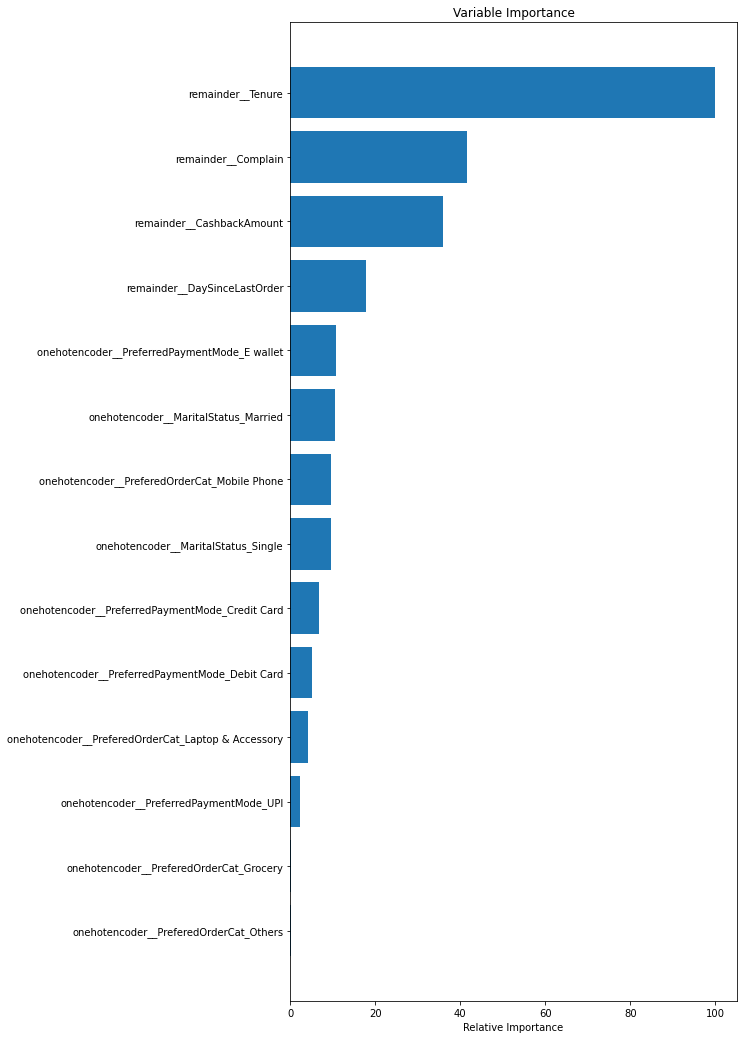

In [451]:
# Plot feature importance https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
feature_importance = gbc_final.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_final.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()